In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Understanding recurrent neural networks

## A first recurrent layer in Keras

Recurrent Neural Networks can easily be implemented in Keras using the `SimpleRNN` layer:

In [2]:
from keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor argument. Let's take a look at an example that uses SimpleRNN and returns only the output at the last timestep:

In [3]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


The following example returns the full state sequence:

In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [6]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17465344/17464789 [==============================] - 5s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [ ]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 12s 580us/step - loss: 0.6432 - acc: 0.6143 - val_loss: 0.4898 - val_acc: 0.7950
Epoch 2/10
20000/20000 [==============================] - 11s 565us/step - loss: 0.4235 - acc: 0.8162 - val_loss: 0.4960 - val_acc: 0.7636
Epoch 3/10
20000/20000 [==============================] - 13s 636us/step - loss: 0.3069 - acc: 0.8757 - val_loss: 0.4178 - val_acc: 0.8208
Epoch 4/10
11776/20000 [================>.............] - ETA: 4s - loss: 0.2294 - acc: 0.9147

Let's display the training and validation loss and accuracy:

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, a few Practicals ago on this very dataset with a very first naive approach that didn't exploit temporal structure we got 88% test accuracy. Unfortunately, our small recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is that our inputs only consider the first 500 words rather the full sequences hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some a more advanced Keras layer that is able to exploit temporal structure.

## A concrete LSTM example in Keras

We will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you having to spend time tuning parameters by hand. Notice also that even a simple LSTM requires a lot of computational resources.

In [12]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 89s 4ms/step - loss: 0.5058 - acc: 0.7671 - val_loss: 0.3406 - val_acc: 0.8754
Epoch 2/10
20000/20000 [==============================] - 74s 4ms/step - loss: 0.2913 - acc: 0.8881 - val_loss: 0.3153 - val_acc: 0.8660
Epoch 3/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.2285 - acc: 0.9140 - val_loss: 0.3217 - val_acc: 0.8784
Epoch 4/10
20000/20000 [==============================] - 80s 4ms/step - loss: 0.1963 - acc: 0.9284 - val_loss: 0.6959 - val_acc: 0.7890
Epoch 5/10
20000/20000 [==============================] - 78s 4ms/step - loss: 0.1775 - acc: 0.9365 - val_loss: 0.2895 - val_acc: 0.8904
Epoch 6/10
20000/20000 [==============================] - 75s 4ms/step - loss: 0.1523 - acc: 0.9449 - val_loss: 0.5011 - val_acc: 0.8640
Epoch 7/10
20000/20000 [==============================] - 73s 4ms/step - loss: 0.1403 - acc: 0.9506 - val_loss: 0.3729 - val_acc:

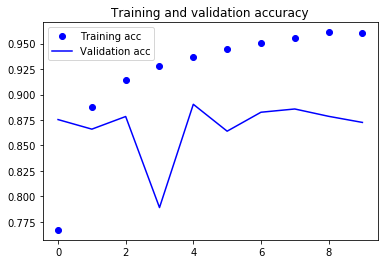

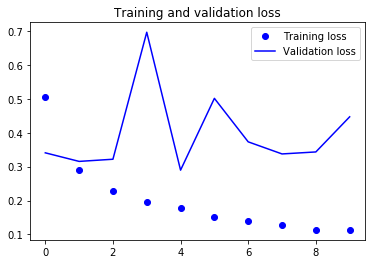

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This time, you achieve up to 89% validation accuracy. Not bad: certainly much better than the SimpleRNN network—that’s largely because LSTM suffers much less from the vanishing-gradient problem—and slightly better than the fully connected approach
from the `2 Classifying movie reviews` practical (lecture 18), even though you’re looking at less data than you were in the `2 Classifying movie reviews` practical. You’re truncating sequences after 500 timesteps, whereas in the `2 Classifying movie reviews` practical, you were considering full sequences.

But this result isn’t groundbreaking for such a computationally intensive approach. Why isn’t LSTM performing better? One reason is that you made no effort to tune hyperparameters such as the embeddings dimensionality or the LSTM output dimensionality. Another may be lack of regularization. But honestly, the primary reason is that analyzing the global, long-term structure of the reviews (what LSTM is good at) isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved by looking at what words occur in each review, and at what frequency. That’s what the first fully connected approach looked at. But there are far more difficult natural language processing problems out there, where the strength of LSTM become apparent: in particular, question-answering and machine translation.